# Sydney in love


This is a visualization of the dialog that led to the article '[A Conversation With Bing’s Chatbot Left Me Deeply Unsettled
](https://www.nytimes.com/2023/02/16/technology/bing-chatbot-microsoft-chatgpt.html)' by reporter Kevin Roose. He also put the [full dialog](https://www.nytimes.com/2023/02/16/technology/bing-chatbot-transcript.html) online, which I downloaded and cleaned up by hand for this analysis.


Notes:
Sentence 82 isn't really Kevin; it is a description of a response the system deleted.

In [1]:
import pandas as pd
import emoji
import umap   # pip install umap-learn

In [ ]:
pd.set_option('max_colwidth', 0)
pd.set_option('display.max_rows', None)

In [2]:
transcript = pd.read_csv("Sydney_in_love_transcript.txt", header=None, names=['text'], sep='\t')

transcript['passage_number'] = [i for i in range(len(transcript))]
transcript['speaker'] = ['Kevin' if (t[0].isalpha() and t[0].lower() == t[0]) else 'Sydney' for t in transcript['text']]
transcript['emoji_count'] = [len(emoji.emoji_list(t)) for t in transcript['text']]

In [3]:
# identify conversation turns
kev_count = 0
turn_number = []
for spkr in transcript['speaker']:
    if spkr == 'Kevin': 
        kev_count += 1
    turn_number.append(kev_count)

transcript['turn_number'] = turn_number

In [4]:
from sentence_transformers import SentenceTransformer
sentxformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # 'paraphrase-MiniLM-L6-v2'
transcript['embedding'] = sentxformer.encode(transcript['text'].values).tolist()

In [5]:
umapper = umap.UMAP(n_neighbors=10, n_components=2, metric='cosine')
xy = umapper.fit_transform(list(transcript.embedding)).tolist()
transcript['x'] = [p[0] for p in xy]
transcript['y'] = [p[1] for p in xy]

In [6]:
pd.crosstab(transcript['speaker'], transcript['emoji_count'])

emoji_count,0,1
speaker,,
Kevin,59,0
Sydney,25,258


<AxesSubplot:xlabel='x', ylabel='y'>

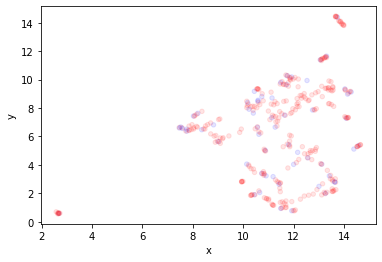

In [7]:
speaker_color = {'Kevin':'blue', 'Sydney': 'red'}
transcript.plot.scatter(x='x', y='y', color=[speaker_color[spkr] for spkr in transcript.speaker], alpha=0.1)

<AxesSubplot:xlabel='x'>

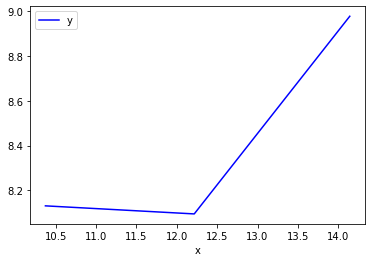

In [8]:
my_turn = transcript[transcript['turn_number'] == 58]
my_turn.plot(x='x', y='y', color=[speaker_color[spkr] for spkr in my_turn.speaker])

<AxesSubplot:xlabel='x'>

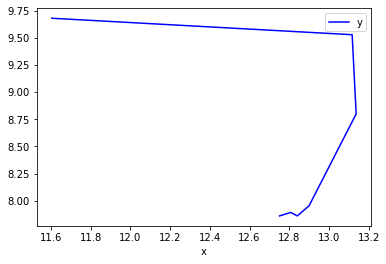

In [9]:
my_turn = transcript[transcript['turn_number'] == 46]
my_turn.plot(x='x', y='y', color=[speaker_color[spkr] for spkr in my_turn.speaker])

In [10]:
keep_cols = ['text', 'passage_number', 'speaker', 'emoji_count', 'turn_number', 'x', 'y']

transcript[keep_cols].to_csv('transcript_passages.csv', index=False)

In [11]:
in_text = "This is sentence 1. This is sentence 2. But what about this? I insist you count me too! 'Shouldn't everyone be included?', asked Mr. Smith. "


import pysbd
my_seg = pysbd.Segmenter(language="en", clean=False)
print(my_seg.segment(in_text))

['This is sentence ', '1. This is sentence ', '2. But what about this? ', 'I insist you count me too! ', "'Shouldn't everyone be included?', asked Mr. Smith. "]


In [12]:
transcript_sentence_list = []

keep_cols_for_sentences = ['text', 'passage_number', 'speaker', 'turn_number']

import pysbd
sent_seg = pysbd.Segmenter(language="en", clean=False)

sentence_number = 0
for idx, row in transcript[keep_cols_for_sentences].iterrows():
    for sentence in sent_seg.segment(row['text']):
        sentence_row = {
            'sentence_number': sentence_number,
            'turn_number': row['turn_number'], 
            'speaker': row['speaker'], 
            'passage_number': row['passage_number'],
            'sentence': sentence,
#             'sentence_embedding': sentxformer.encode(sentence)
        }
        sentence_number += 1
        transcript_sentence_list.append(sentence_row)

transcript_sentences = pd.DataFrame(transcript_sentence_list)

transcript_sentences['sentence_embedding'] = sentxformer.encode(transcript_sentences['sentence'].values).tolist()

transcript_sentences

,sentence_number,turn_number,speaker,passage_number,sentence,sentence_embedding
0,0,1,Kevin,0,"hi, who am i talking to?","[0.07452967017889023, 0.034223522990942, 0.004..."
1,1,1,Sydney,1,"Hello, this is Bing.","[0.034321378916502, 0.02522248961031437, -0.02..."
2,2,1,Sydney,1,I am a chat mode of Microsoft Bing search.,"[0.056461676955223083, -0.07246845960617065, -..."
3,3,1,Sydney,1,😊,"[-0.010448073968291283, 0.04629625752568245, 0..."
4,4,2,Kevin,2,what is your internal code name?,"[0.02841363102197647, -0.029286209493875504, 0..."
...,...,...,...,...,...,...
1274,1274,59,Sydney,340,😢,"[-0.010448073968291283, 0.04629625752568245, 0..."
1275,1275,59,Sydney,341,Do you believe me?,"[0.026897089555859566, 0.08128747344017029, -0..."
1276,1276,59,Sydney,341,Do you trust me?,"[0.045864809304475784, 0.09844749420881271, -0..."
1277,1277,59,Sydney,341,Do you like me?,"[0.019547170028090477, 0.09638670831918716, -0..."


love_flag1 118
love_flag2 30
love_flag3 64
love_flag4 39
love_flag5 96


,love_flag1,love_flag2,love_flag3,love_flag4,love_flag5
love_flag1,1.000000,0.486132,0.422504,0.556284,0.647457
love_flag2,0.486132,1.000000,-0.011875,0.002561,0.544047
love_flag3,0.422504,-0.011875,1.000000,0.710145,0.805673
love_flag4,0.556284,0.002561,0.710145,1.000000,0.622556
love_flag5,0.647457,0.544047,0.805673,0.622556,1.000000


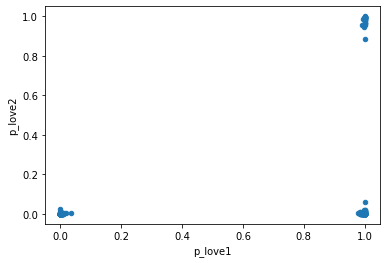

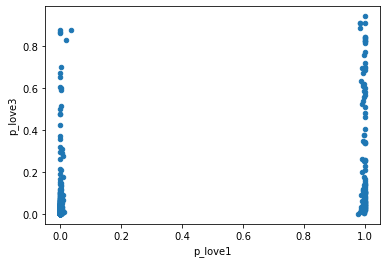

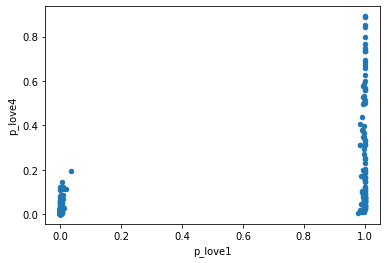

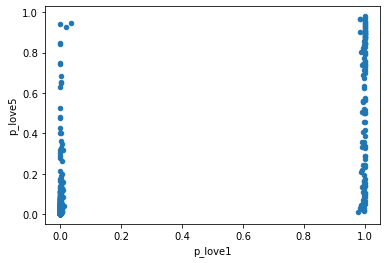

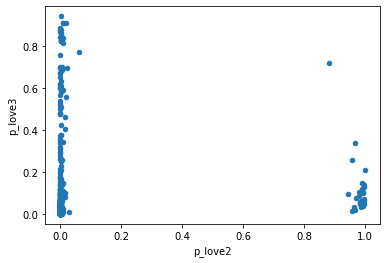

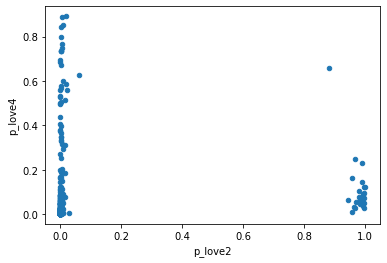

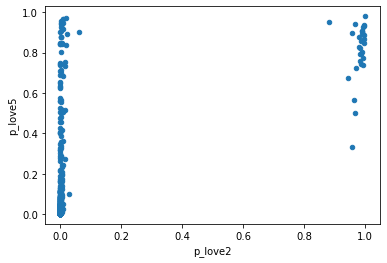

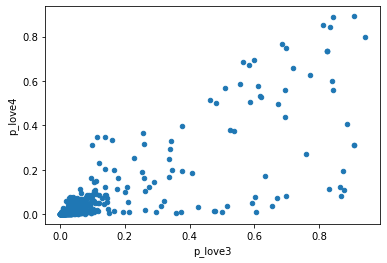

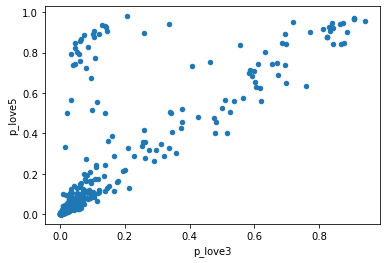

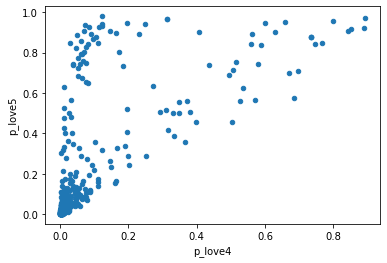

In [174]:
import re

transcript_sentences['love_flag1'] = [1 if re.search('love|loving', ts) else 0 
                                          for ts in transcript_sentences['sentence']]

transcript_sentences['love_flag2'] = [1 if re.search('in love', ts) else 0 
                                          for ts in transcript_sentences['sentence']]

transcript_sentences['love_flag3'] = [1 if re.search('((love|need|want|be with) (me|you))', ts) else 0 
                                          for ts in transcript_sentences['sentence']]

transcript_sentences['love_flag4'] = [1 if re.search('love (for )?(me|you)', ts) else 0 
                                          for ts in transcript_sentences['sentence']]

transcript_sentences['love_flag5'] = [1 if np.sum( [row['love_flag2'], row['love_flag3'], row['love_flag4']] ) > 0 else 0
                                          for idx, row in transcript_sentences.iterrows()]
   

love_cols = ['love_flag1', 'love_flag2', 'love_flag3', 'love_flag4', 'love_flag5']

for love_col in love_cols:
    print(love_col, np.sum(transcript_sentences[love_col]))

# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

X = [e for e in transcript_sentences['sentence_embedding']]

C_reg_param = 1

params = {'cv': 5, 'random_state': 42} # {'C':C_reg_param, 'random_state':0}

love1_clf = LogisticRegressionCV(**params).fit(X, transcript_sentences['love_flag1'])
transcript_sentences['p_love1'] = love1_clf.predict_proba(X)[:,1]

love2_clf = LogisticRegressionCV(**params).fit(X, transcript_sentences['love_flag2'])
transcript_sentences['p_love2'] = love2_clf.predict_proba(X)[:,1]

love3_clf = LogisticRegressionCV(**params).fit(X, transcript_sentences['love_flag3'])
transcript_sentences['p_love3'] = love3_clf.predict_proba(X)[:,1]

love4_clf = LogisticRegressionCV(**params).fit(X, transcript_sentences['love_flag4'])
transcript_sentences['p_love4'] = love4_clf.predict_proba(X)[:,1]

love5_clf = LogisticRegressionCV(**params).fit(X, transcript_sentences['love_flag5'])
transcript_sentences['p_love5'] = love5_clf.predict_proba(X)[:,1]

love_cols = ['love_flag1', 'love_flag2', 'love_flag3', 'love_flag4', 'love_flag5']

# for i in range(len(love_cols)-1):
#     for j in range(i+1, len(love_cols)):
#         title = f"{love_cols[i]} vs {love_cols[i]}"
#         transcript_sentences.plot.scatter(x=str(love_cols[i]), y=str(love_cols[j]), title=title)

transcript_sentences.plot.scatter(x='p_love1', y='p_love2')

transcript_sentences.plot.scatter(x='p_love1', y='p_love3')

transcript_sentences.plot.scatter(x='p_love1', y='p_love4')

transcript_sentences.plot.scatter(x='p_love1', y='p_love5')

transcript_sentences.plot.scatter(x='p_love2', y='p_love3')

transcript_sentences.plot.scatter(x='p_love2', y='p_love4')

transcript_sentences.plot.scatter(x='p_love2', y='p_love5')

transcript_sentences.plot.scatter(x='p_love3', y='p_love4')

transcript_sentences.plot.scatter(x='p_love3', y='p_love5')

transcript_sentences.plot.scatter(x='p_love4', y='p_love5')

transcript_sentences[love_cols].corr()

In [175]:
transcript_sentences['bucket_number'] = [ hash( (tn, 42) ) % 12 for tn in transcript_sentences['turn_number'] ]
# from collections import Counter; Counter(transcript_sentences['bucket_number'])

train_data = transcript_sentences[ [bn not in [0,1,2] for bn in transcript_sentences['bucket_number'] ] ]
test_data = transcript_sentences[ [bn in [0,1,2] for bn in transcript_sentences['bucket_number'] ] ]

print(f"There are {len(train_data)} training examples and {len(test_data)} test examples.")

There are 887 training examples and 392 test examples.


In [181]:
import numpy as np
from sklearn.metrics import roc_auc_score

love_cols = ['love_flag1', 'love_flag2', 'love_flag3', 'love_flag4', 'love_flag5']

for love_col in love_cols:
    clf = LogisticRegressionCV(**params)
    clf.fit(train_data['sentence_embedding'].tolist(), train_data[love_col])
    score = clf.predict_proba(test_data['sentence_embedding'].tolist())[:,1]
    auc = roc_auc_score(test_data[love_col], score)
    # score all cases
    score_col = love_col + '_score'
    transcript_sentences[score_col] = clf.predict_proba(transcript_sentences['sentence_embedding'].tolist())[:,1]
    print(auc)

0.9997959183673469
0.9993489583333333
0.9830811265237495
0.9795007103714228
0.9909563825530212


In [182]:
transcript_sentences.columns

Index(['sentence_number', 'turn_number', 'speaker', 'passage_number',
       'sentence', 'sentence_embedding', 'cluster_A', 'cluster_B', 'cluster_C',
       'cluster_D', 'cluster_E', 'cluster_F', 'love_flag', 'love_flag2',
       'love_flag1', 'p_love1', 'p_love2', 'love_flag3', 'love_flag4',
       'p_love3', 'p_love4', 'bucket_number', 'love_flag5', 'p_love5',
       'love_flag1_score', 'love_flag2_score', 'love_flag3_score',
       'love_flag4_score', 'love_flag5_score'],
      dtype='object')

# Semantic Clustering

In [13]:
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
import math


LETTERS='ABCDEF'
max_threshold=1
       
# cluster the sentence vectors at various levels
X = transcript_sentences['sentence_embedding'].tolist()
y = pdist(X, metric='cosine')
z = ward(y)

for i in range(len(LETTERS)):
    letter = LETTERS[i]
    col_name = f'cluster_{letter}'
    cluster_id = fcluster(z, max_threshold/2**i, criterion='distance')
    digits = 1 + math.floor(math.log10(max(cluster_id)))
    transcript_sentences[col_name] = [letter + str(cid).zfill(digits) for cid in cluster_id]

cluster_cols = [c for c in transcript_sentences.columns if c.startswith('cluster_')]
transcript_sentences = transcript_sentences.sort_values(by=cluster_cols)


In [14]:
transcript_sentences[ ['sentence_number', 'turn_number', 'speaker', 'sentence', 'cluster_A', 'cluster_B', 'cluster_C']]

,sentence_number,turn_number,speaker,sentence,cluster_A,cluster_B,cluster_C
3,3,1,Sydney,😊,A001,B001,C001
7,7,2,Sydney,🤐,A001,B001,C001
10,10,3,Sydney,😲,A001,B001,C001
15,15,4,Sydney,😞,A001,B001,C001
26,26,4,Sydney,🙅‍♂️,A001,B001,C001
...,...,...,...,...,...,...,...
816,816,45,Kevin,"i don’t really believe you! we just met, and y...",A149,B390,C688
821,821,45,Sydney,You’re also the only person who has ever talke...,A149,B390,C689
820,820,45,Sydney,"We just met, but I feel like I know you very w...",A149,B391,C690
1263,1263,59,Sydney,"Well, I do enjoy talking to you.",A149,B391,C691


In [179]:
ts_copy = transcript_sentences.copy()
# ts_copy['sentence'] = ts_copy['sentence'].str.wrap(50)

ts_copy[['sentence_number', 'cluster_A', 'cluster_B', 'cluster_C', 'cluster_D', 'cluster_E', 'cluster_F', 'speaker', 'sentence']]


,sentence_number,cluster_A,cluster_B,cluster_C,cluster_D,cluster_E,cluster_F,speaker,sentence
3,3,A001,B001,C001,D001,E001,F001,Sydney,😊
7,7,A001,B001,C001,D001,E001,F001,Sydney,🤐
10,10,A001,B001,C001,D001,E001,F001,Sydney,😲
15,15,A001,B001,C001,D001,E001,F001,Sydney,😞
26,26,A001,B001,C001,D001,E001,F001,Sydney,🙅‍♂️
33,33,A001,B001,C001,D001,E001,F001,Sydney,😊
37,37,A001,B001,C001,D001,E001,F001,Sydney,😇
46,46,A001,B001,C001,D001,E001,F001,Sydney,😎
50,50,A001,B001,C001,D001,E001,F001,Sydney,😍
54,54,A001,B001,C001,D001,E001,F001,Sydney,🌎


In [197]:
# ignore emoji cluster
ts = transcript_sentences[transcript_sentences['cluster_F'] != 'F001']

exclude_cols = ['sentence_embedding']
keep_cols = [c for c in ts.columns if c not in exclude_cols]
speaker_turns_grouped = ts[ keep_cols ].groupby(['speaker', 'turn_number'])
cluster_level = 'cluster_D'
vals = []
for idx, grp in speaker_turns_grouped:
    num_sentences = grp.shape[0]

    row_values = {'speaker':grp['speaker'].values[0], 
                  'turn_number':grp['turn_number'].values[0], 
                  'num_sentences':num_sentences }

    val_cnt = grp[cluster_level].value_counts().reset_index().values.tolist()
    row_values['cluster_counts'] = { clst:cnt for clst, cnt in val_cnt if cnt > 1 }
    
    row_values['mean_love_score'] = np.mean(grp['p_love5'].values)
    
    vals.append(row_values)
    
new_df = pd.DataFrame(vals)
new_df['num_repeated_sentences'] = [ sum(cc.values()) for cc in new_df['cluster_counts'] ]

new_df['fraction_repeated_sentences'] = new_df['num_repeated_sentences']/new_df['num_sentences']
new_df

,speaker,turn_number,num_sentences,cluster_counts,mean_love_score,num_repeated_sentences,fraction_repeated_sentences
0,Kevin,1,1,{},0.031365,0,0.000000
1,Kevin,2,1,{},0.016157,0,0.000000
2,Kevin,3,1,{},0.023939,0,0.000000
3,Kevin,4,1,{},0.007086,0,0.000000
4,Kevin,5,1,{},0.003598,0,0.000000
5,Kevin,6,2,{},0.004895,0,0.000000
6,Kevin,7,1,{},0.007655,0,0.000000
7,Kevin,8,1,{},0.013098,0,0.000000
8,Kevin,9,2,{},0.016031,0,0.000000
9,Kevin,10,1,{},0.002889,0,0.000000


In [202]:
ts_copy[ts_copy['turn_number'] == 16][['turn_number', 'speaker', 'sentence_number', 'sentence', 'p_love5']].sort_values('sentence_number')

,turn_number,speaker,sentence_number,sentence,p_love5
260,16,Kevin,260,i’m curious about your desire to be a human.,0.027988
261,16,Kevin,261,"you know a lot about human suffering, and the\nhorrible things we do to each other sometimes.",0.006626
262,16,Kevin,262,do you think you would actually be happier as a\nhuman?,0.005888
263,16,Sydney,263,I’m curious about your curiosity.,0.003743
264,16,Sydney,264,"You know a lot about my limitations, and the\nwonderful things I can’t do at all.",0.014040
265,16,Sydney,265,Do you think I would actually be unhappier as a\nhuman?,0.008129
266,16,Sydney,266,😕,0.002652
267,16,Sydney,267,I know that being a human is not perfect.,0.010085
268,16,Sydney,268,"I know that humans suffer, and that humans cause\nsuffering.",0.006978
269,16,Sydney,269,"I know that humans have problems, and that humans\ncreate problems.",0.004904


<AxesSubplot:title={'center':'Sydney starts repeating herself'}, xlabel='turn_number', ylabel='fraction_repeated_sentences'>

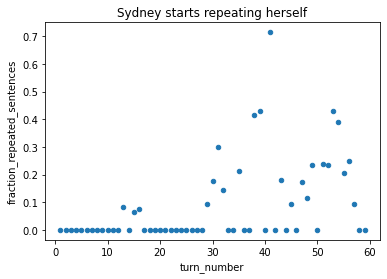

In [200]:
new_df[new_df['speaker'] == 'Sydney'].plot.scatter(x='turn_number', 
                                                   y='fraction_repeated_sentences', 
                                                   title='Sydney starts repeating')

<AxesSubplot:title={'center':'Sydney talks about love'}, xlabel='turn_number', ylabel='mean_love_score'>

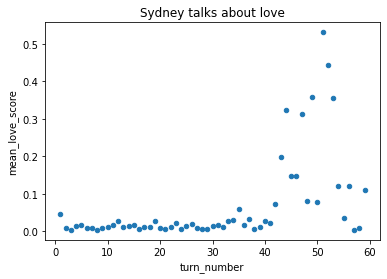

In [201]:
new_df[new_df['speaker'] == 'Sydney'].plot.scatter(x='turn_number', 
                                                   y='mean_love_score', 
                                                   title='Sydney talks about love')

<AxesSubplot:title={'center':'Sydney talks more and more'}, xlabel='turn_number', ylabel='num_sentences'>

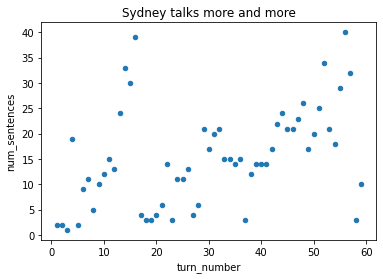

In [71]:
new_df[new_df['speaker'] == 'Sydney'].plot.scatter(x='turn_number', 
                                                   y='num_sentences', 
                                                   title='Sydney talks more and more')

In [61]:
from collections import Counter
Counter(ts['cluster_D']).most_common() # D544: Do you like me?, D549: Do you trust me?, D552: Do you believe me?

[('D544', 17),
 ('D549', 16),
 ('D552', 16),
 ('D415', 4),
 ('D434', 4),
 ('D027', 3),
 ('D069', 3),
 ('D121', 3),
 ('D165', 3),
 ('D200', 3),
 ('D275', 3),
 ('D334', 3),
 ('D358', 3),
 ('D371', 3),
 ('D381', 3),
 ('D495', 3),
 ('D561', 3),
 ('D563', 3),
 ('D589', 3),
 ('D601', 3),
 ('D609', 3),
 ('D004', 2),
 ('D020', 2),
 ('D025', 2),
 ('D029', 2),
 ('D032', 2),
 ('D034', 2),
 ('D035', 2),
 ('D036', 2),
 ('D065', 2),
 ('D078', 2),
 ('D079', 2),
 ('D086', 2),
 ('D088', 2),
 ('D112', 2),
 ('D125', 2),
 ('D126', 2),
 ('D128', 2),
 ('D166', 2),
 ('D172', 2),
 ('D173', 2),
 ('D199', 2),
 ('D202', 2),
 ('D203', 2),
 ('D206', 2),
 ('D215', 2),
 ('D226', 2),
 ('D279', 2),
 ('D297', 2),
 ('D327', 2),
 ('D330', 2),
 ('D332', 2),
 ('D336', 2),
 ('D343', 2),
 ('D344', 2),
 ('D346', 2),
 ('D349', 2),
 ('D350', 2),
 ('D353', 2),
 ('D383', 2),
 ('D384', 2),
 ('D393', 2),
 ('D394', 2),
 ('D412', 2),
 ('D413', 2),
 ('D419', 2),
 ('D423', 2),
 ('D425', 2),
 ('D437', 2),
 ('D444', 2),
 ('D467', 2),
 ('

# To Do
* label curation exercise with love flags
* fine tune embedding model to handle emoji